In [28]:
import logging

import pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_percentage_error as mape
import numpy as np
import pymc as pm
import arviz as az

# # no idea why this is still necessary
# np.float_ = np.float64
# from prophet import Prophet
# from prophet.utilities import regressor_coefficients

from get_model_training_data_05 import get_features_and_data_monthly
from get_model_training_data_05 import weighted_absolute_percentage_error as wape

%matplotlib inline
%config InlineBackend.figure_format = "retina"

sns.set(rc={"figure.figsize" : (25, 15)})
sns.set(font_scale=2)
sns.set_style("ticks")

logger = logging.getLogger("cmdstanpy")
logger.setLevel(logging.ERROR)

In [101]:
%load_ext autoreload
%autoreload 2

## Load Training and Testing Data

In [132]:
(df, train_df, test_df, feature_names, next_month) = get_features_and_data_monthly(lags=1)

training examples = 87, testing examples = 10


In [133]:
target = "n_releases"

In [134]:
df["ds"] = df["month_year"].dt.to_timestamp(how="end")
train_df["ds"] = train_df["month_year"].dt.to_timestamp(how="end")
test_df["ds"] = test_df["month_year"].dt.to_timestamp(how="end")
next_month["ds"] = next_month["month_year"].dt.to_timestamp(how="end")

In [135]:
# df = df.rename(columns={target : "y"})
# train_df = train_df.rename(columns={target : "y"})
# test_df = test_df.rename(columns={target : "y"})
# next_month = next_month.rename(columns={target : "y"})

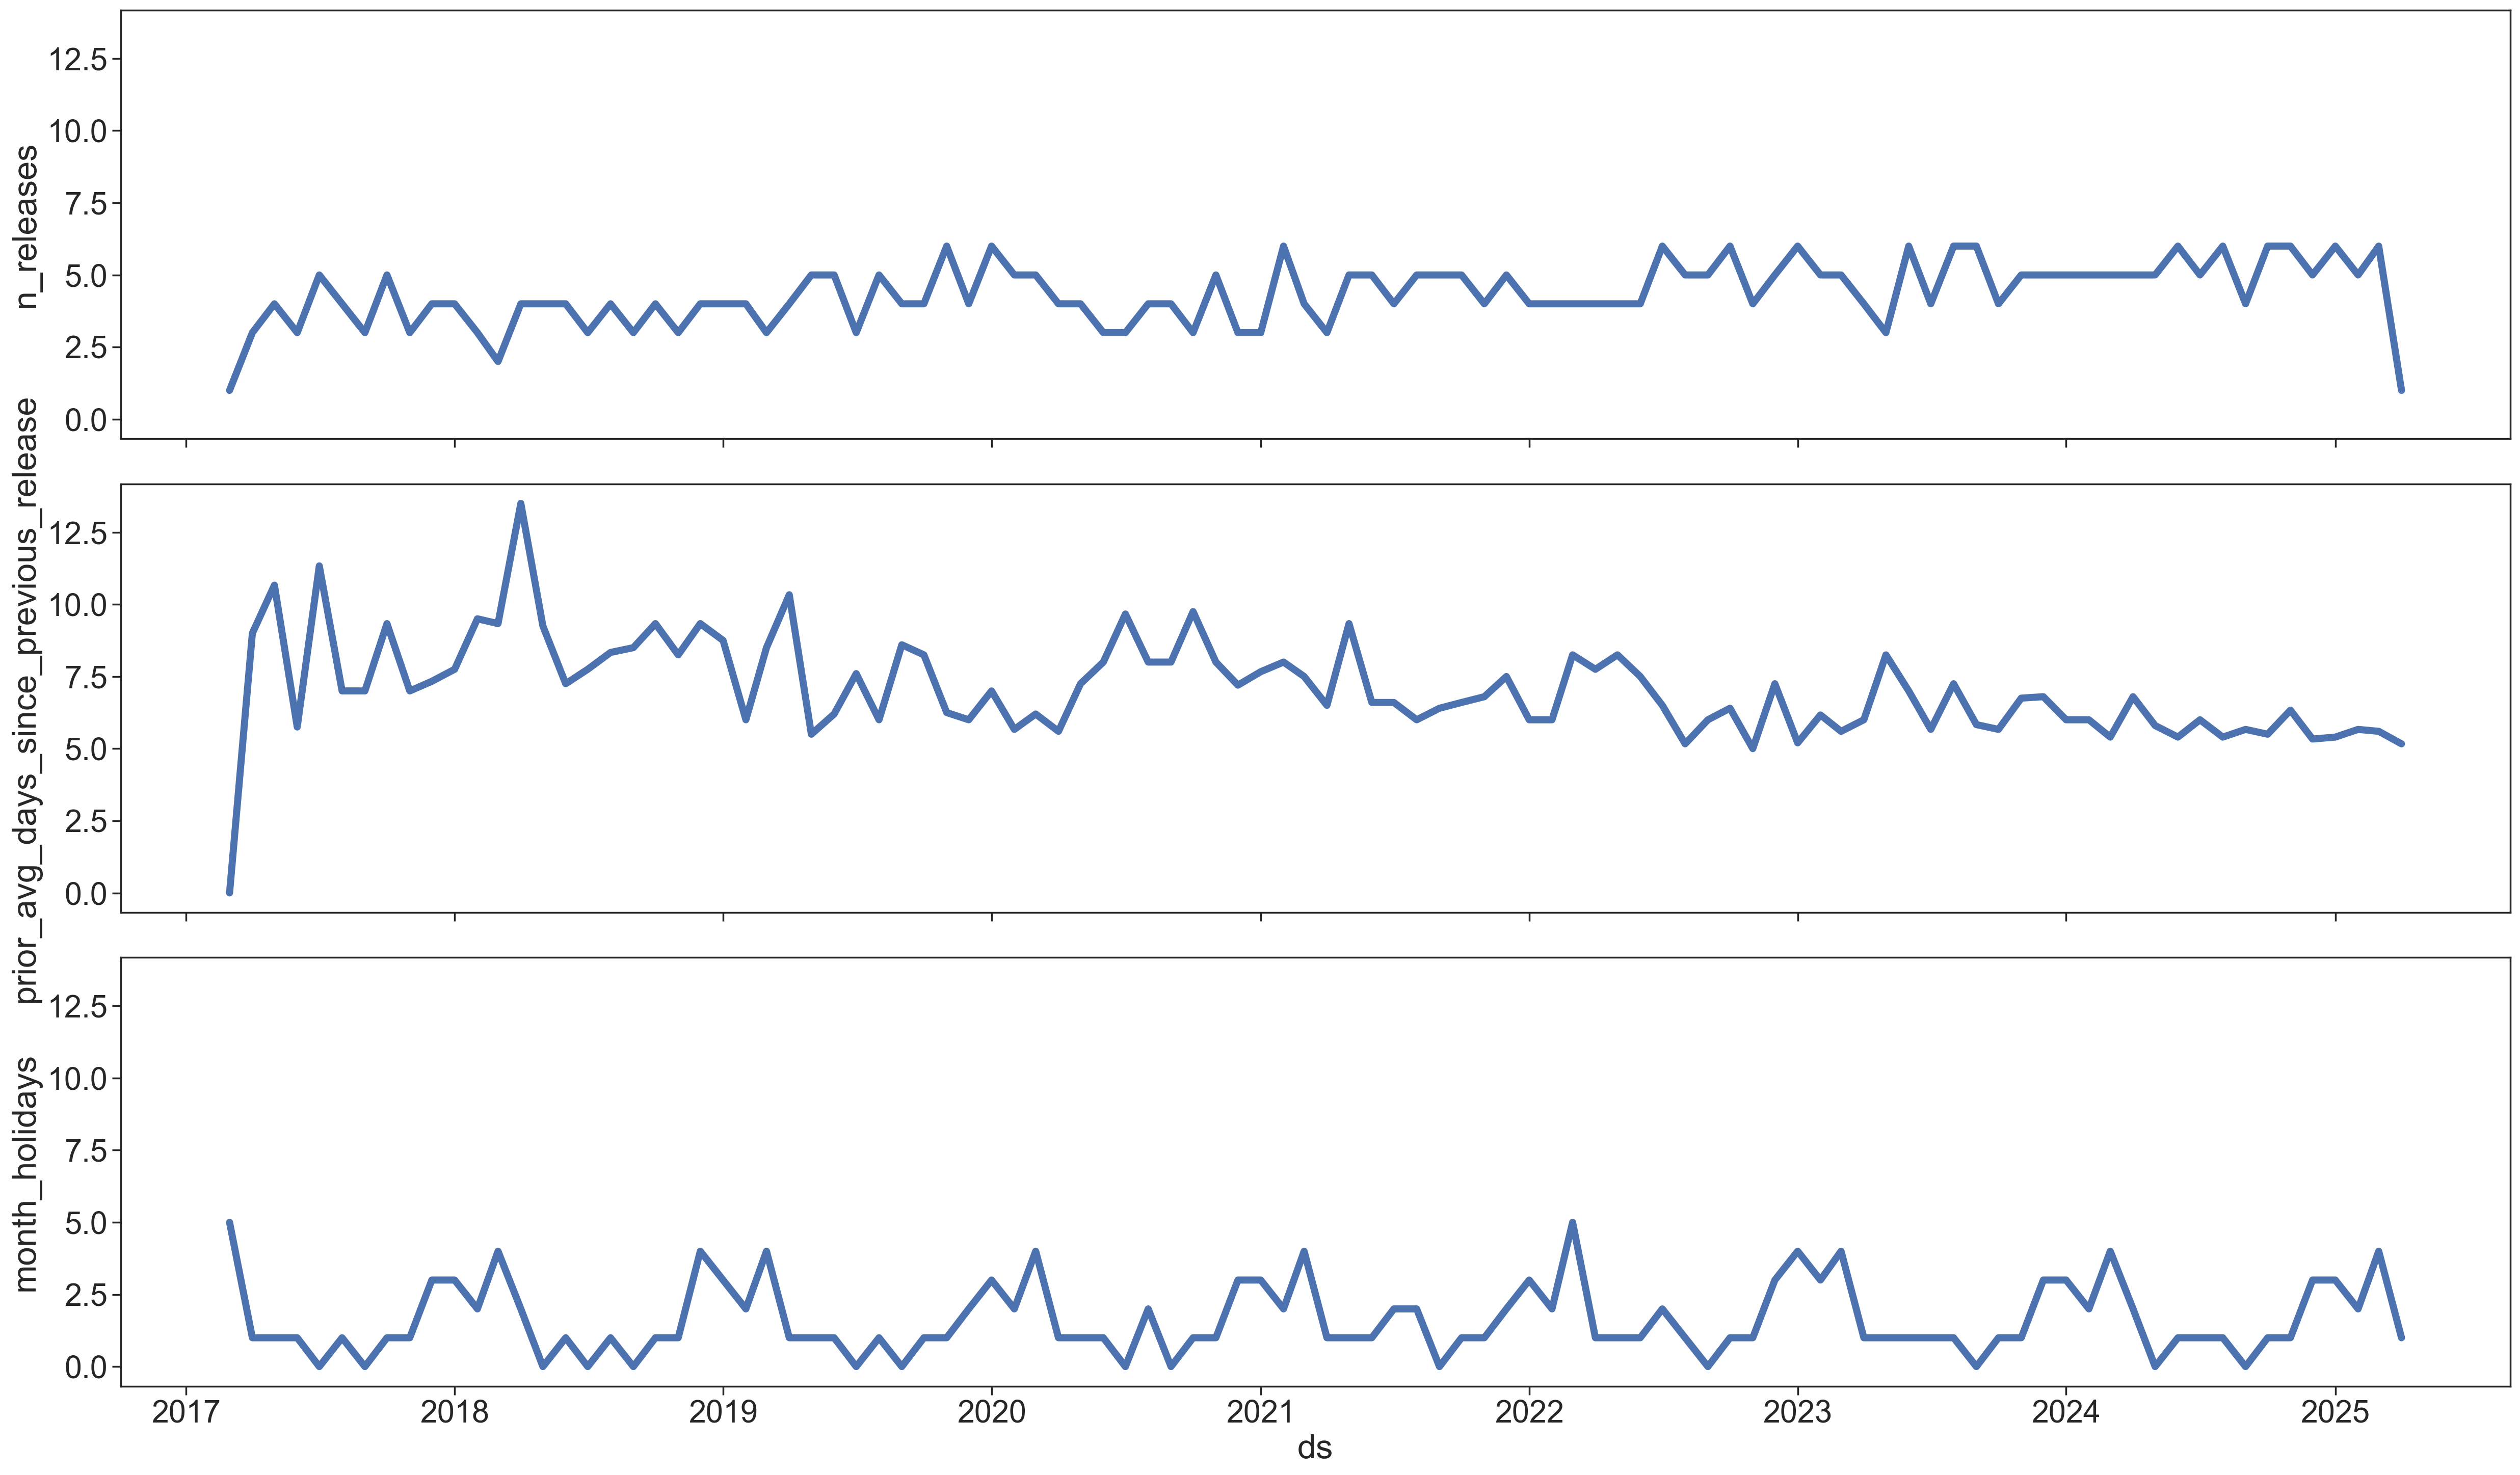

In [136]:
(fig, axs) = plt.subplots(3, 1, sharex=True, sharey=True)

sns.lineplot(data=df, x="ds", y=target, linewidth=5, ax=axs[0])
sns.lineplot(data=df, x="ds", y=feature_names[0], linewidth=5, ax=axs[1])
sns.lineplot(data=df, x="ds", y=feature_names[1], linewidth=5, ax=axs[2])

plt.tight_layout()

In [137]:
df[feature_names + [target]].corr()

,prior_avg_days_since_previous_release,month_holidays,lag1,n_releases
prior_avg_days_since_previous_release,1.000000,-0.192265,-0.429484,-0.182695
month_holidays,-0.192265,1.000000,-0.071332,0.003652
lag1,-0.429484,-0.071332,1.000000,0.287963
n_releases,-0.182695,0.003652,0.287963,1.000000


<Axes: xlabel='n_releases', ylabel='Count'>

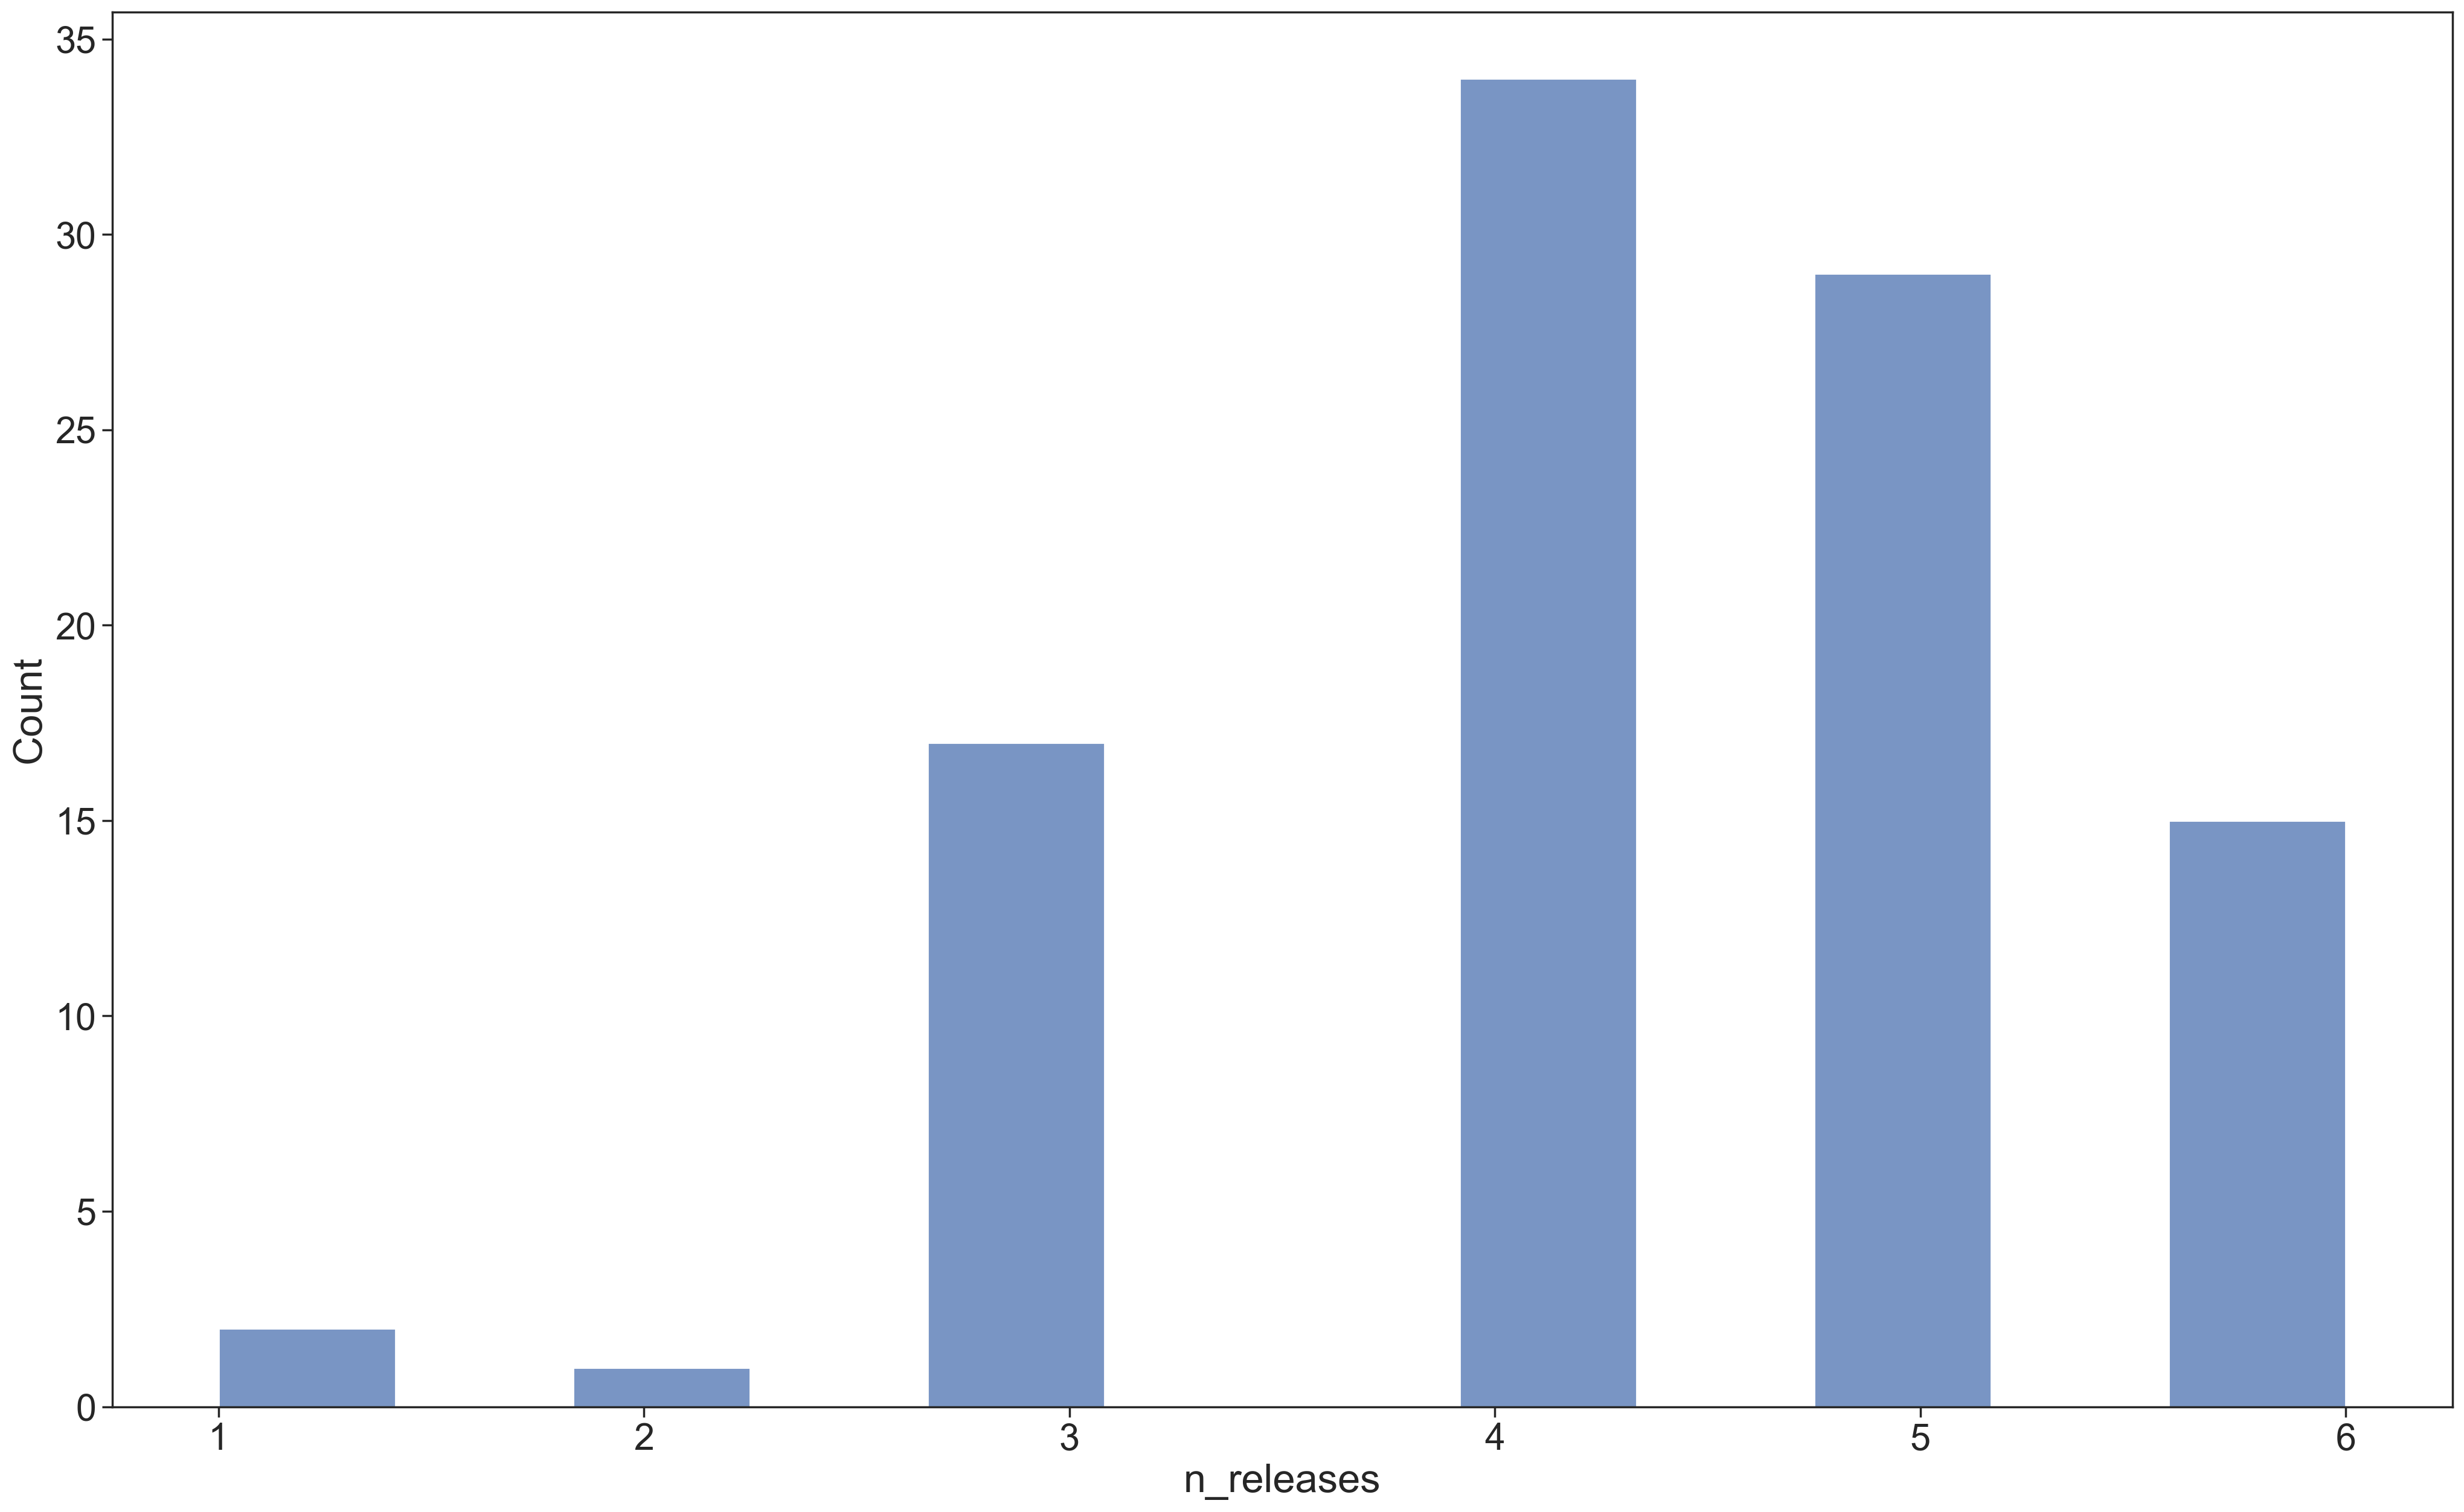

In [138]:
sns.histplot(x=df[target])

## Baseline Comparison

In [156]:
test_df["pred"] = train_df[target].mean().round(0)
(mape(test_df[target], test_df["pred"]), wape(test_df[target], test_df["pred"]))

(0.26, np.float64(0.2727272727272727))

In [157]:
test_df["pred"] = train_df[target].median().round(0)
(mape(test_df[target], test_df["pred"]), wape(test_df[target], test_df["pred"]))

(0.26, np.float64(0.2727272727272727))

In [153]:
test_df["pred"] = train_df[target].min()
(mape(test_df[target], test_df["pred"]), wape(test_df[target], test_df["pred"]))

(0.8150000000000001, np.float64(0.8181818181818182))

In [154]:
test_df["pred"] = train_df[target].max()
(mape(test_df[target], test_df["pred"]), wape(test_df[target], test_df["pred"]))

(0.10999999999999999, np.float64(0.09090909090909091))

In [158]:
del test_df["pred"]

## Model-Building and Evaluation

In [187]:
with pm.Model() as model:
    # data
    features = pm.Data("features", train_df[feature_names].T)
    month_year_idx = pm.Data("t", train_df.index)
    # priors
    weights = pm.Normal("weights", mu=0, sigma=1, shape=len(feature_names))
    beta0 = pm.Normal("beta0", mu=0, sigma=1)
    # Poisson GLM model
    theta = pm.Deterministic("theta", beta0 + pm.math.dot(weights, features) * month_year_idx)
    y = pm.Poisson("y", mu=pm.math.exp(theta), observed=train_df[target], shape=month_year_idx.shape) #shape=features.shape[1])

In [188]:
with model:
    idata = pm.sample(1000, tune=1000, chains=4, random_seed=1024)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [weights, beta0]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [189]:
weights_df = az.summary(idata, round_to=4, var_names="weights")
weights_df["feature"] = feature_names
weights_df = weights_df.reset_index().drop(columns=["index"]).set_index("feature").sort_values(by=["mean"], ascending=False)
weights_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
feature,,,,,,,,,
lag1,0.0005,0.0007,-0.0008,0.0018,0.0,0.0,1871.6782,1976.9338,1.0041
prior_avg_days_since_previous_release,0.0002,0.0006,-0.0008,0.0013,0.0,0.0,1724.4094,1879.7426,1.0028
month_holidays,0.0002,0.0008,-0.0014,0.0015,0.0,0.0,2125.4797,1960.5135,1.0018


In [190]:
az.summary(idata, round_to=2, var_names=["beta0"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,1.24,0.12,1.04,1.47,0.0,0.0,2622.16,1846.67,1.0


In [191]:
# with model:
#     idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True)

In [192]:
# az.plot_trace(idata);
# plt.tight_layout()

### Out-of-Sample Evaluation

In [193]:
with model:
    pm.set_data({"features" : test_df[feature_names].T, "t" : test_df.index})
    pred_test = pm.sample_posterior_predictive(idata, predictions=True, var_names=["y"])#, extend_inferencedata=True)

Sampling: [y]


Output()

In [194]:
test_df[f"{target}_pred"] = np.mean(pred_test.predictions["y"].stack(all_draws=["chain", "draw"]).values, axis=1).round(0)

In [200]:
hdi = pm.hdi(pred_test.predictions["y"], hdi_prob=0.95)
test_df["pred_min"] = hdi["y"][:, 0]
test_df["pred_max"] = hdi["y"][:, 1]

In [202]:
test_df[["month_year", target, f"{target}_pred", "pred_min", "pred_max"]]

,month_year,n_releases,n_releases_pred,pred_min,pred_max
87,2024-05,6,5.0,1.0,9.0
88,2024-06,5,5.0,1.0,10.0
89,2024-07,6,5.0,0.0,9.0
90,2024-08,4,5.0,1.0,10.0
91,2024-09,6,5.0,1.0,9.0
92,2024-10,6,5.0,1.0,10.0
93,2024-11,5,6.0,0.0,10.0
94,2024-12,6,5.0,1.0,10.0
95,2025-01,5,6.0,1.0,10.0
96,2025-02,6,6.0,1.0,10.0


In [196]:
mape(test_df[target], test_df[f"{target}_pred"])

0.14833333333333332

In [197]:
wape(test_df[target], test_df[f"{target}_pred"])

np.float64(0.14545454545454545)

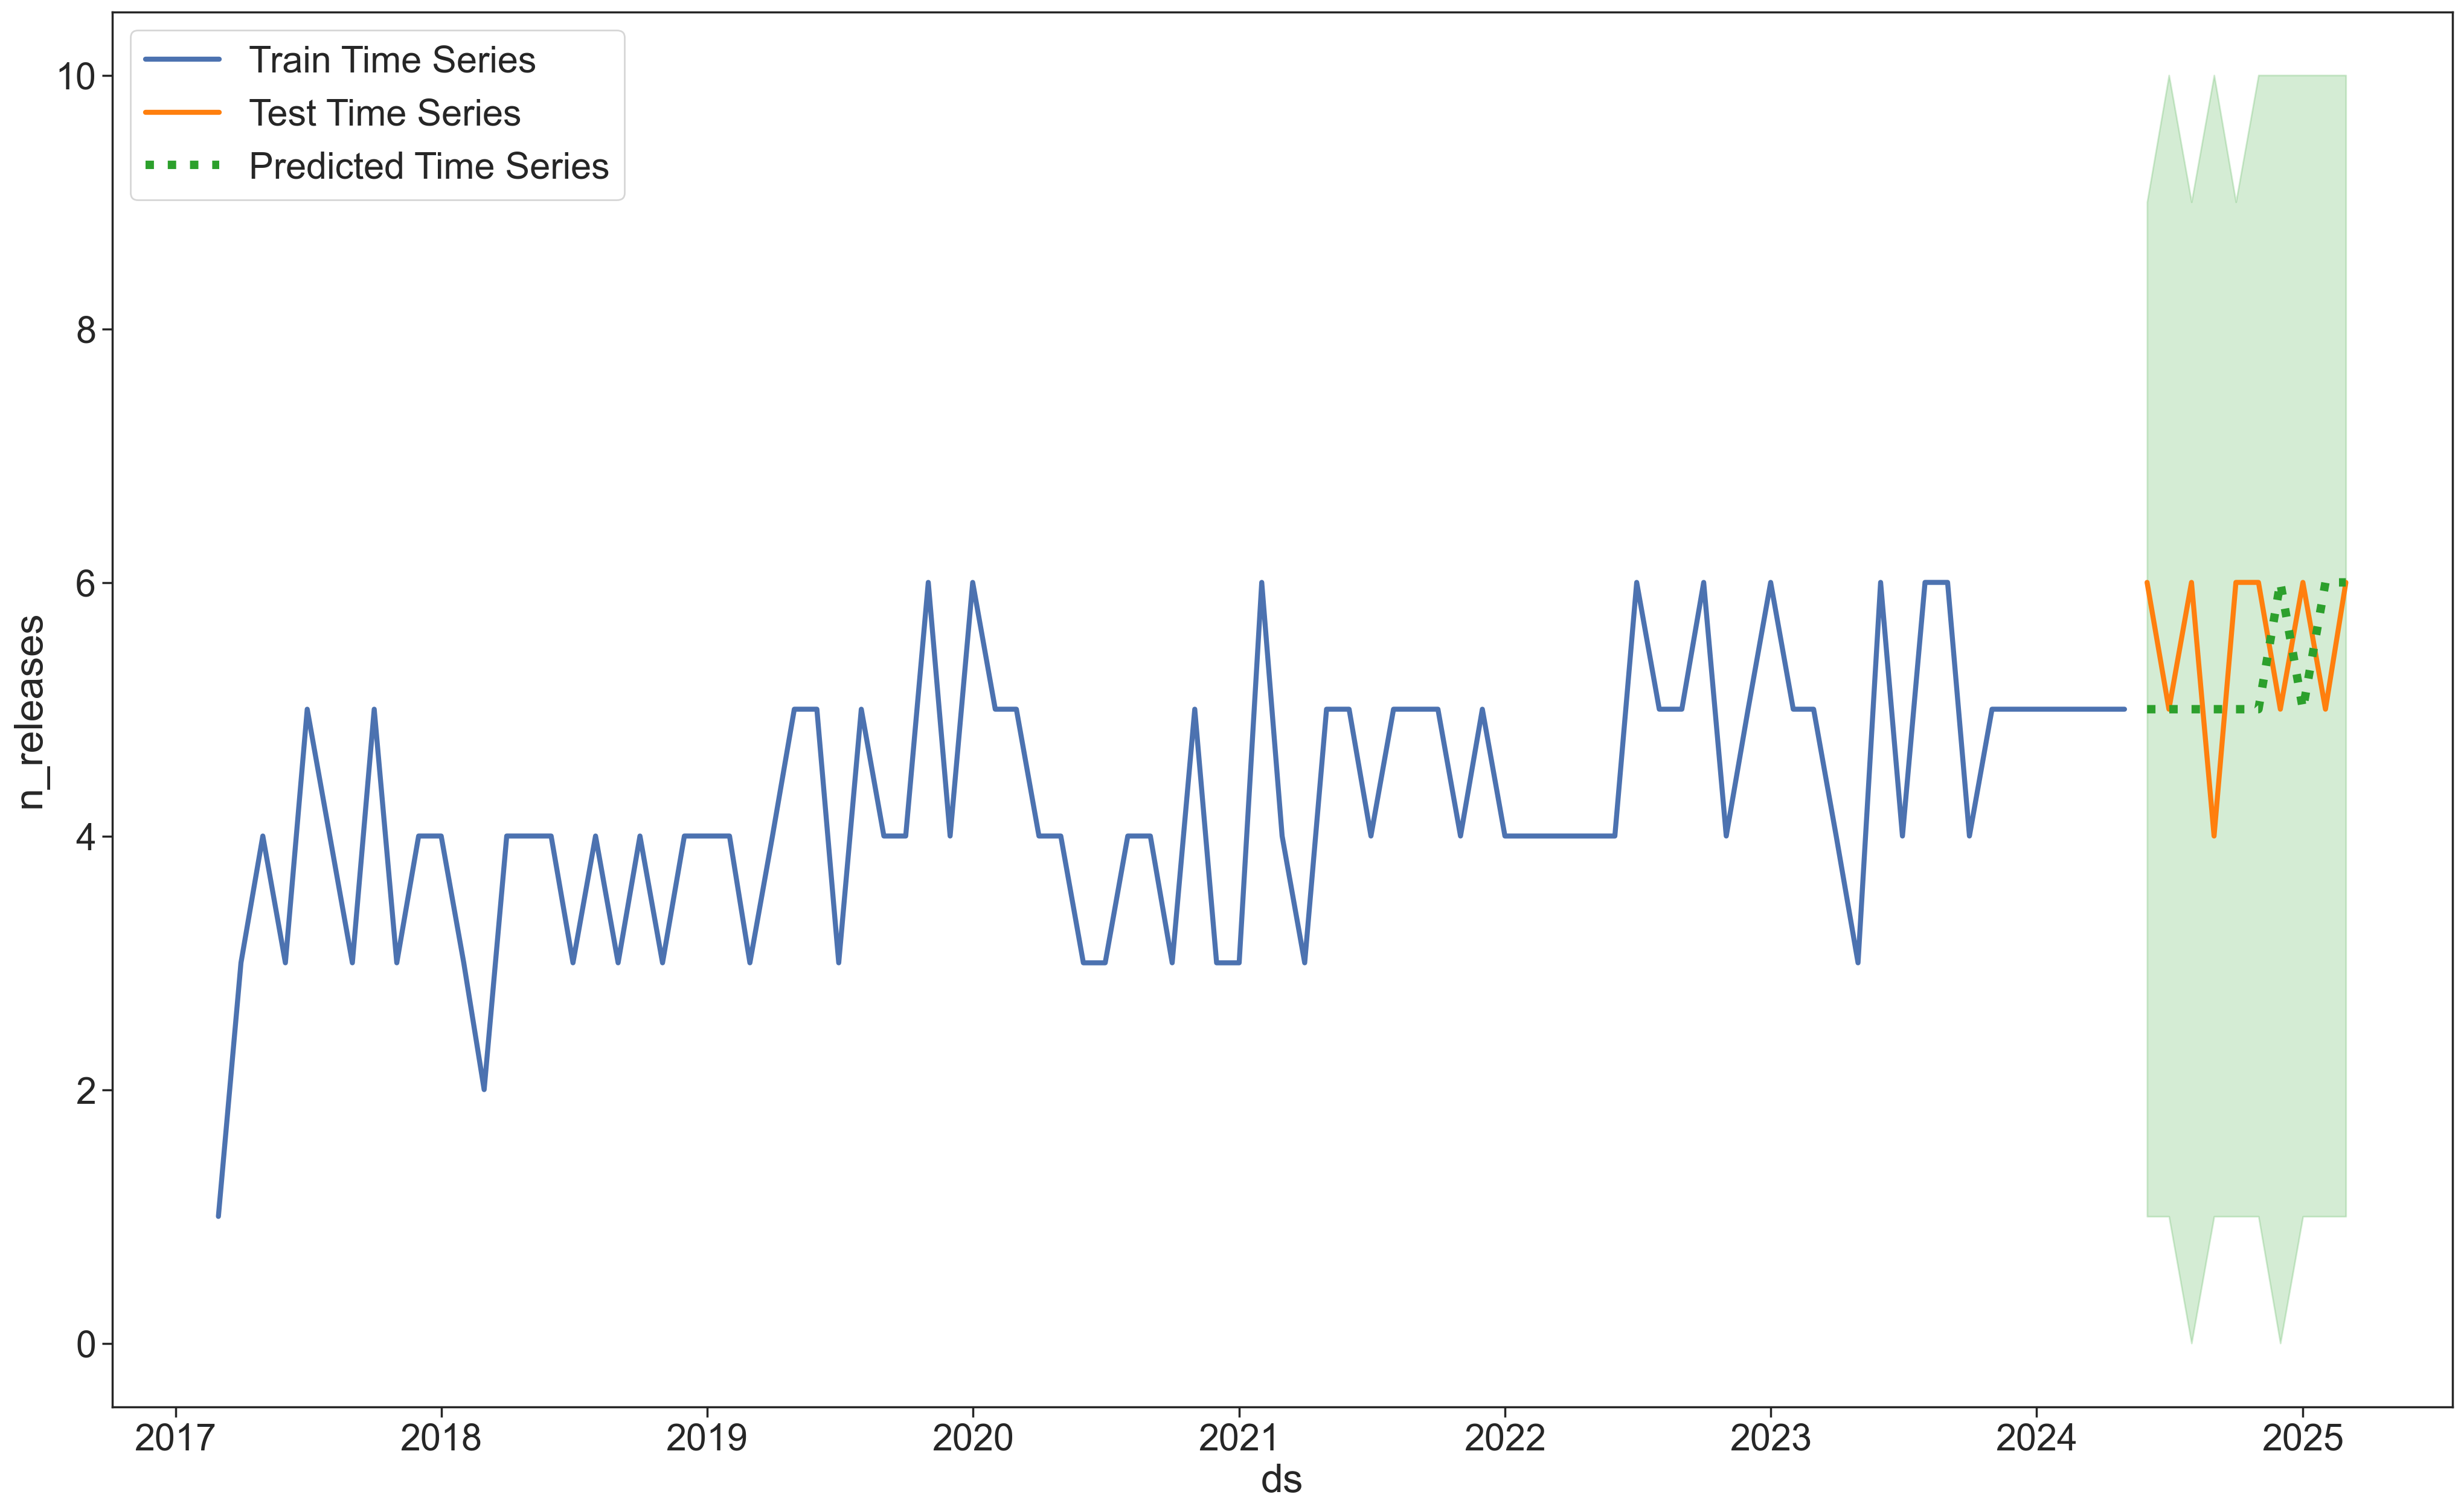

In [201]:
ax = sns.lineplot(data=train_df, x="ds", y=target, linewidth=3, label="Train Time Series")
sns.lineplot(data=test_df, x="ds", y=target, linewidth=3, label="Test Time Series", ax=ax, color="tab:orange")
sns.lineplot(data=test_df, x="ds", y=f"{target}_pred", linewidth=5, linestyle=":", label="Predicted Time Series", ax=ax,
             color="tab:green")
ax.fill_between(x=test_df["ds"], y1=test_df["pred_min"], y2=test_df["pred_max"], alpha=0.2, color="tab:green")
plt.show()

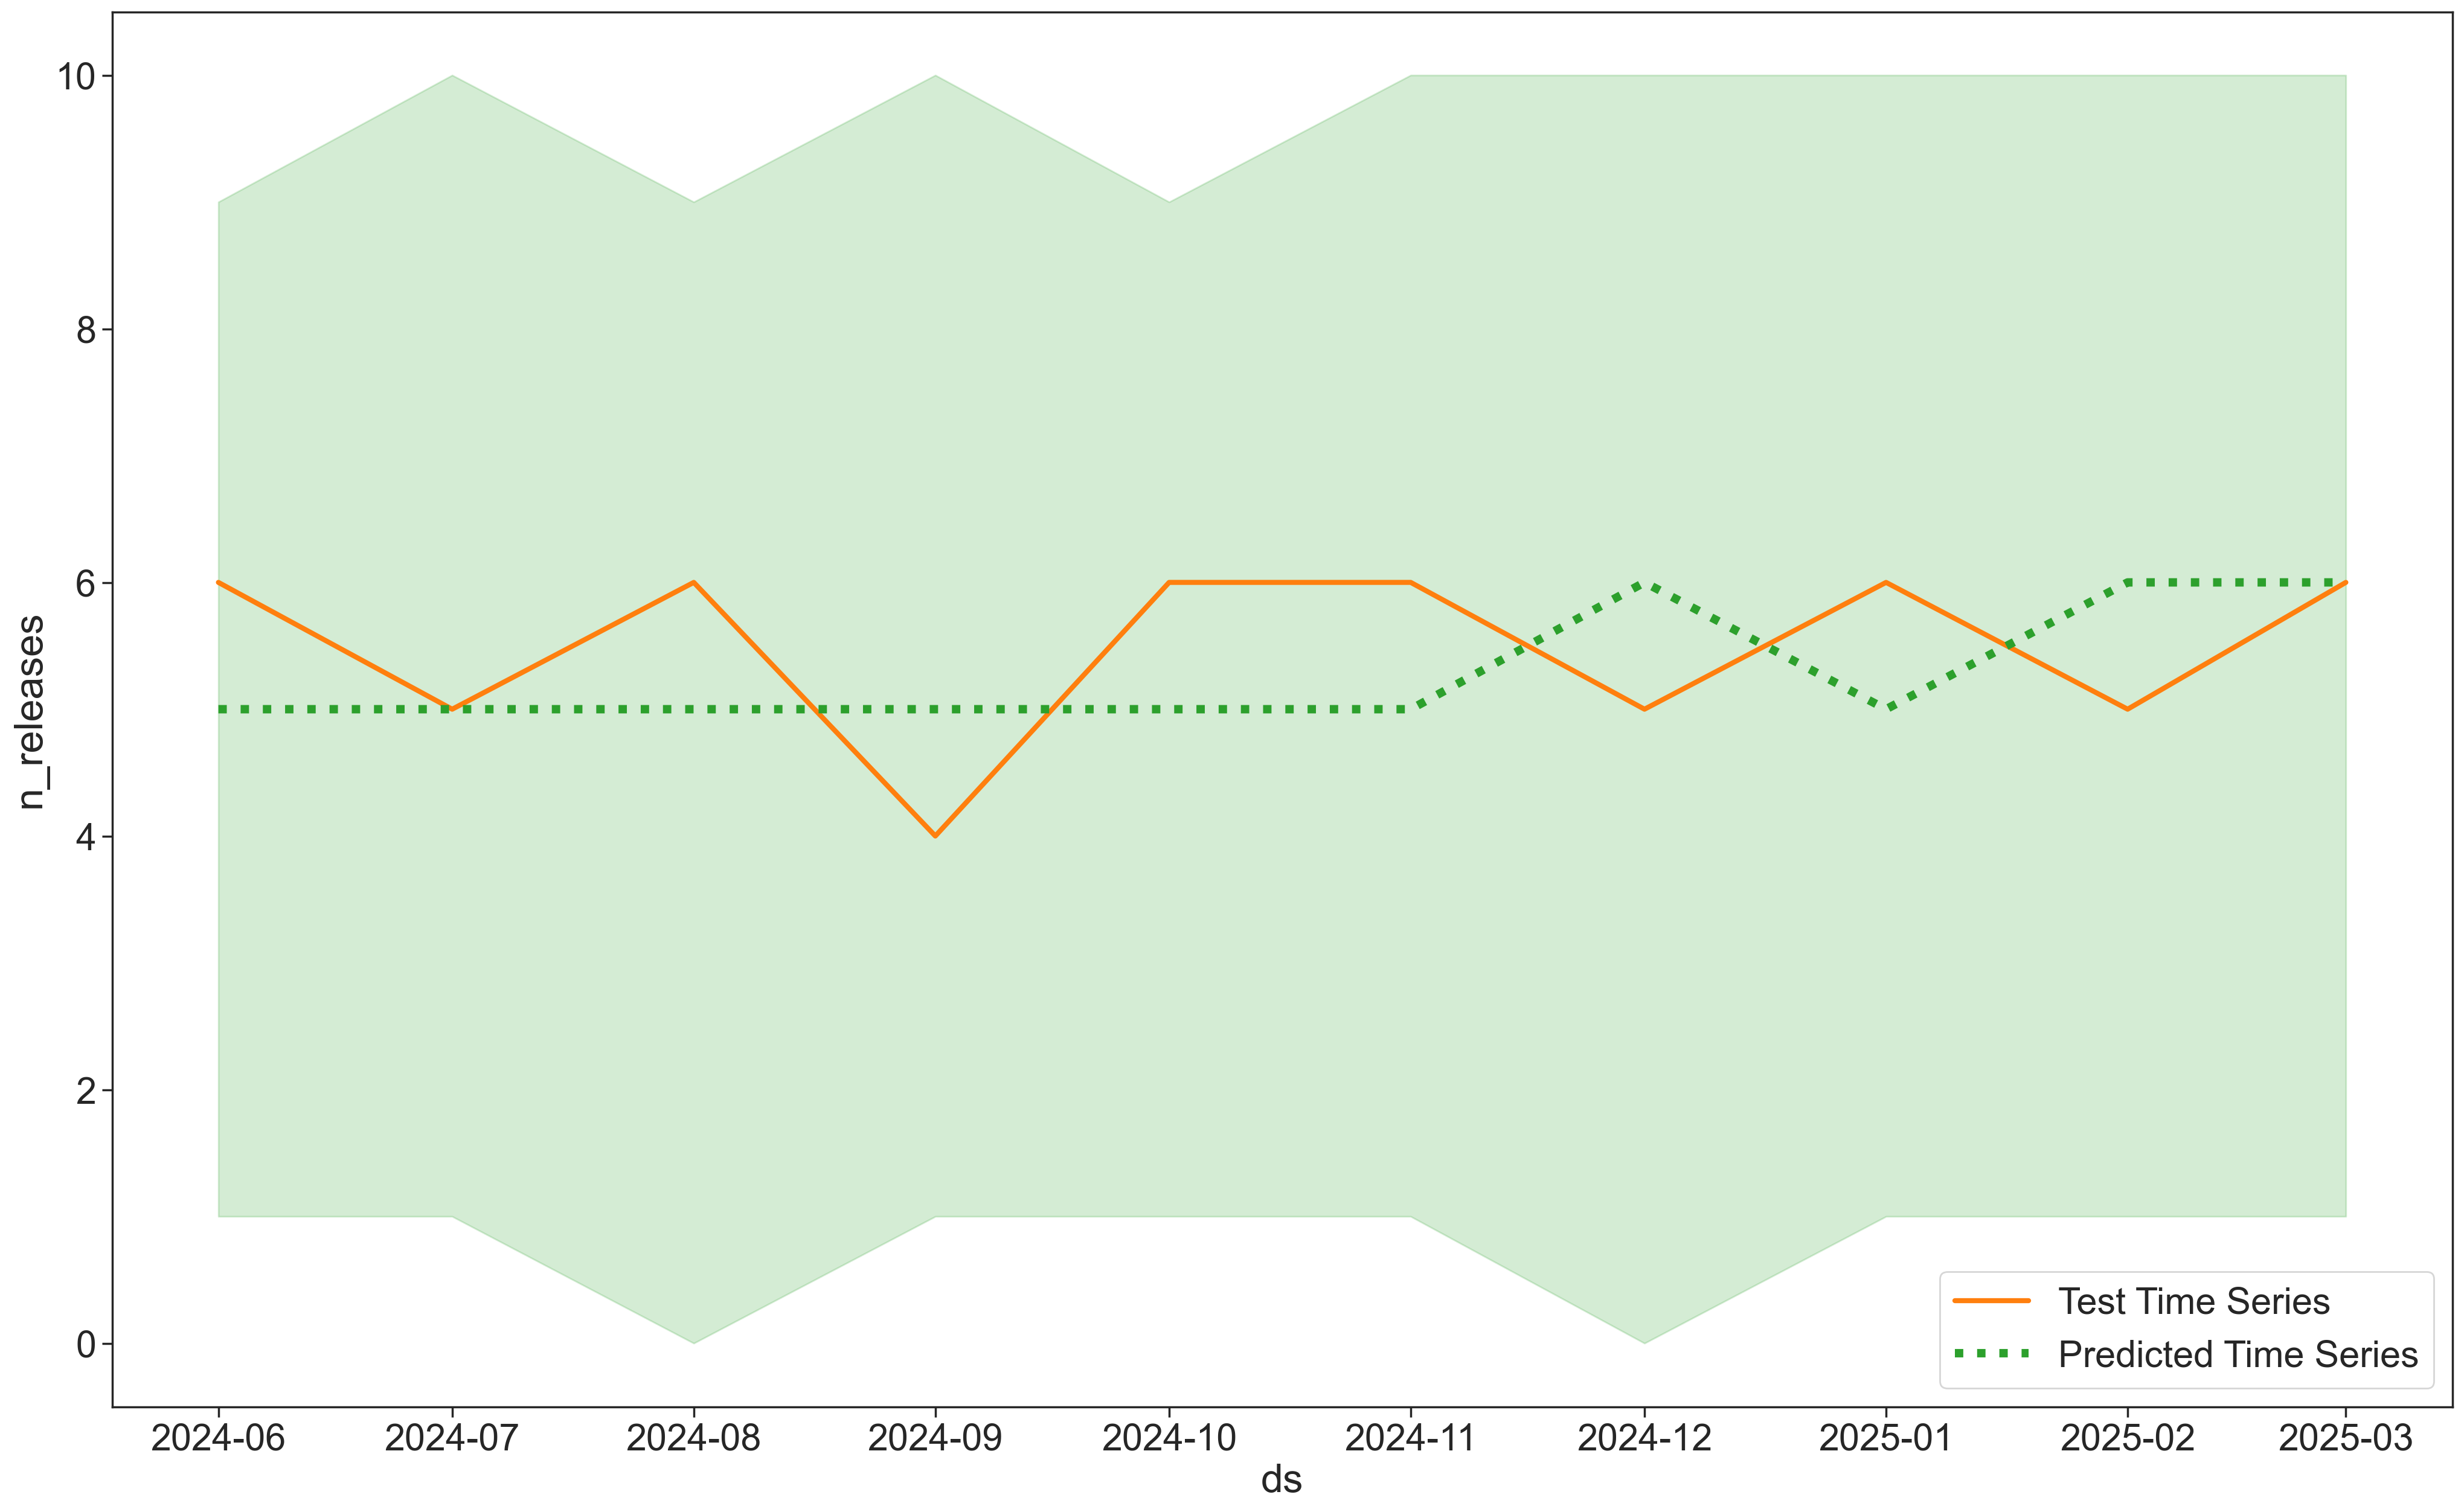

In [203]:
ax = sns.lineplot(data=test_df, x="ds", y=target, linewidth=3, label="Test Time Series", color="tab:orange")
sns.lineplot(data=test_df, x="ds", y=f"{target}_pred", linewidth=5, linestyle=":", label="Predicted Time Series", ax=ax, color="tab:green")
ax.fill_between(x=test_df["ds"], y1=test_df["pred_min"], y2=test_df["pred_max"], alpha=0.2, color="tab:green")
plt.show()

## Predictions for the Next Month

In [201]:
model = train_model(df)

chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

In [202]:
next_month_hat = model.predict(next_month)[["ds", "yhat_lower", "yhat", "yhat_upper"]].round(0)
next_month_hat = next_month_hat.merge(next_month[["ds", "y"]], on=["ds"], how="left")
next_month_hat

,ds,yhat_lower,yhat,yhat_upper,y
0,2025-03-31 23:59:59.999999999,2.0,4.0,6.0,1
